In [1]:
using Pkg
Pkg.activate()

import Pkg
Pkg.add(path="/home/harsh/Work/code/KadanoffBaym.jl")
include("/home/harsh/Work/code/KadanoffBaym.jl")
#import KandaoffBaym
using KadanoffBaym
#reload("KadanoffBaym.jl")

using Catalyst

using LinearAlgebra
#Pkg.update(LinearAlgebra)

Pkg.add("BlockArrays")
using BlockArrays

#Pkg.add("ChainRulesCore")
using ChainRulesCore

using Distributions
#Pkg.add("Distributions")

#Pkg.add("PyPlot")
using PyPlot

#using DifferentialEquations

#using Plots

#import Pkg;
#Pkg.add("IterTools")
using IterTools

#Pkg.build("PyCall")

#Pkg.add("Einsum")
using Einsum

  Activating project at `~/.julia/environments/v1.9`
    Updating git-repo `/net/theorie/home/harsh/Work/code/KadanoffBaym.jl`
   Resolving package versions...
  No Changes to `/net/theorie/home/harsh/.julia/environments/v1.9/Project.toml`
  No Changes to `/net/theorie/home/harsh/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `/net/theorie/home/harsh/.julia/environments/v1.9/Project.toml`
  No Changes to `/net/theorie/home/harsh/.julia/environments/v1.9/Manifest.toml`


In [2]:
using KadanoffBaym

In [ ]:
kbsolve!()

In [2]:
"""
    Response

Defined as 
`` G(t,t') = 0 if t' > t ``
"""
struct Response <: KadanoffBaym.AbstractSymmetry end

@inline KadanoffBaym.symmetry(::Type{Response}) = zero


In [3]:
#Parameters simulation
tmax = 2.
atol = 1e-6
rtol = 1e-4

0.0001

## Define the reaction system and the defaults or initialization using Catalyst

In [156]:
rs_aaa = @reaction_network AAA begin
    @species A(t)= 4. /3
    @parameters k1A = 1 k2A = 1 k3 = 1 
  (k3), A+A --> A
  (k2A,k1A), A <--> 0 
end

Model AAA
States (1):
  A(t) [defaults to 1.33333]
Parameters (3):
  k1A [defaults to 1]
  k2A [defaults to 1]
  k3 [defaults to 1]

In [183]:
rs_aaa2 = @reaction_network AAA_back begin
    @species A(t)= 4. /3
    @parameters k1A = 1 k2A = 1 k3 = 1 k3_back = 1
  (k3,k3_back), A+A --> A
  (k2A,k1A), A <--> 0 
end

Model AAA_back
States (1):
  A(t) [defaults to 1.33333]
Parameters (4):
  k1A [defaults to 1]
  k2A [defaults to 1]
  k3 [defaults to 1]
  k3_back [defaults to 1]

In [192]:
rs_abc = @reaction_network ABC_back begin
    @species A(t)= 4. /3 B(t) = 2.0 C(t) = 1.0
    @parameters k1A = 4 k1B = 4 k1C = 3 k2A = 3 k2B = 2 k2C = 3 k3 = 1 k3_back = 1.2
  (k3,k3_back), A+B <--> C
  (k2A,k1A), A <--> 0
  (k2B,k1B), B <--> 0
  (k2C,k1C), C <--> 0  
end

Model ABC_back
States (3):
  A(t) [defaults to 1.33333]
  B(t) [defaults to 2.0]
  C(t) [defaults to 1.0]
Parameters (8):
  k1A [defaults to 4]
  k1B [defaults to 4]
  k1C [defaults to 3]
  k2A [defaults to 3]
  k2B [defaults to 2]
  k2C [defaults to 3]
⋮

In [3]:
rs_abc2 = @reaction_network ABC begin
    @species A(t) = 4. /3 B(t) = 2.0 C(t) = 1.0
    @parameters k1A = 4 k1B = 4 k1C = 3 k2A = 3 k2B = 2 k2C = 3 k3 = 1.
  (k3), A+B --> C
  (k2A,k1A), A <--> 0
  (k2B,k1B), B <--> 0
  (k2C,k1C), C <--> 0  
end

Model ABC
States (3):
  A(t) [defaults to 1.33333]
  B(t) [defaults to 2.0]
  C(t) [defaults to 1.0]
Parameters (7):
  k1A [defaults to 4]
  k1B [defaults to 4]
  k1C [defaults to 3]
  k2A [defaults to 3]
  k2B [defaults to 2]
  k2C [defaults to 3]
⋮

## Morph the reaction structure from Catalyst to one more useful for us:

In [4]:
Base.@kwdef struct Reaction_structure{T1,T2,T3,T4}
    
    num_species::T1 = 0
    num_interactions::T1 = 0
    num_reactions::T1 = 2*num_species + num_interactions
    
    rate_creation::T2    = zeros(0)
    rate_destruction::T2 = zeros(0)
    rate_interaction::T4 = zeros(0) #Should this data type be T3?
    
    stochiometry_prod::T3  = zeros(0)
    stochiometry_react::T3 = zeros(0)
    
    initial_values::T4 = zeros(0)
    
end

function Reaction_structure(reaction_system::ReactionSystem,external_initialization=false)
    
    """
    TODO: Add support for external initialization
    """
    
    num_int        = 0
    initial_values = zeros(numspecies(reaction_system))
    k1             = zeros(numspecies(reaction_system))
    k2             = zeros(numspecies(reaction_system))
    k3             = zeros(0)
    s_i            = zeros(Int64,(numspecies(reaction_system),0))
    r_i            = zeros(Int64,(numspecies(reaction_system),0))
    temp_index     = 1

    for i in reactions(reaction_system)
        if length(dependents(i,reaction_system)) == 1 && length(i.products) == 0 
            #The destruction reaction
            sp     = speciesmap(reaction_system)[i.substrates[1]]
            k2[sp] = reaction_system.defaults[i.rate]

        elseif length(dependents(i,reaction_system)) == 0 
            #The spontaneous creation reaction
            sp     = speciesmap(reaction_system)[i.products[1]]
            k1[sp] = reaction_system.defaults[i.rate]

        else 
            #The interaction reactions rates
            append!(k3,reaction_system.defaults[i.rate])

            #For stochiometry
            s_i = cat(s_i,prodstoichmat(reaction_system)[:,temp_index],dims=2)
            r_i = cat(r_i,substoichmat(reaction_system)[:,temp_index],dims=2)
            num_int += 1
        end
        temp_index += 1
    end

    #Store the initial values
    for i in species(reaction_system)
        sp = speciesmap(reaction_system)[i]
        initial_values[sp] = reaction_system.defaults[i]

    end
    
    return Reaction_structure(num_species = numspecies(reaction_system),
                                            num_interactions  = num_int,
                                            rate_creation     = k1,
                                            rate_destruction  = k2,
                                            rate_interaction  = k3,
                                            stochiometry_prod = s_i,
                                            stochiometry_react= r_i,
                                            initial_values    = initial_values)
end

Reaction_structure

In [14]:
structure = Reaction_structure(rs_abc)

Reaction_structure{Int64, Vector{Float64}, Matrix{Int64}, Vector{Float64}}(3, 2, 8, [4.0, 4.0, 3.0], [3.0, 2.0, 3.0], [1.0, 1.2], [0 1; 0 1; 1 0], [1 0; 1 0; 0 1], [1.3333333333333333, 2.0, 1.0])

In [5]:
Base.@kwdef struct Reaction_variables
    
    R = 0 
    μ = 0
    C = 0
    Σ_R = 0
    Σ_μ = 0
    Σ_B = 0
    
end

function Reaction_variables(reaction_system::Reaction_structure,response_type="cross")
    
    if response_type == "single"
        
        R = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response)
        R[:,:,1,1] = ones(reaction_system.num_species)
        μ = GreenFunction(zeros(Float64,reaction_system.num_species,1), OnePoint)
        μ[:,1] = reaction_system.initial_values
        
        return Reaction_variables( 
            R = R,
            μ = μ,
            Σ_R = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response),
            Σ_μ = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response))
        
    elseif response_type == "cross"
        
        R = GreenFunction(zeros(Float64,reaction_system.num_species,reaction_system.num_species,1,1), Response)
        R[:,:,1,1] = ones(reaction_system.num_species,reaction_system.num_species)
        μ = GreenFunction(zeros(Float64,reaction_system.num_species,1), OnePoint)
        μ[:,1] = reaction_system.initial_values
        
        return Reaction_variables( 
            R = R,
            μ = μ,
            Σ_R = GreenFunction(zeros(Float64,reaction_system.num_species,reaction_system.num_species,1,1), Response),
            Σ_μ = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response))
    end

end

Reaction_variables

In [781]:
variables = Reaction_variables(structure,"single");

## Solve using the KB package:

In [202]:
#cmn defined with t-1 and the first c0n or c01 defined with t+1

function solve_dynamics(structure,variables,atol,rtol,tmax,tstart=0.)
    
    function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy correction to the mean
        """

        retval = zero(μ[t1])

        for k in 1:tmax
            retval +=  Σ[t1,k]*hs[k]
        end
        
        return retval
    end

    function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy corrections to the response
        """

        retval = zero(R[t1,t2])

        for k in t2+1:t1
            #retval += Σ[t1,k].*R[k,t2].*hs[k] #Need to add a shift here? --IMP (PAY ATTENTION!)
            retval += Σ[t1,k].*R[k-1,t2].*hs[k-1] #This has been shifted! PAY ATTENTION!
        end

        return retval
    end
    
    # Right-hand side for the "vertical" evolution
    function fv!(structure, variables, out, times, h1, h2, t, t′)
        
        if t == 1
            #self_energy_mak!(structure, variables, times, h1, h1 , t, t) #-- not needed called while calling f1
            corr = variables.Σ_R[t,t]

        else
            corr = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        end
        
        retval  = zero(variables.R[t,t′])
        #corr    = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        
        for j in 1:structure.num_species
            retval[j] = -structure.rate_destruction[j].*variables.R[j,t,t′]
        end

        out[1]  .= retval + corr

    end

    function fd!(structure, variables, out, times, h1, h2, t, t′)
         #diagonal evolution
        
        out[1] = zero(out[1])
        
    end


    function f1!(structure, variables, out, times, h1, t)
        # one-time equation for condensate amplitude
        
        if t == 1
            
            self_energy_mak!(structure, variables, times, h1, h1 , t, t)
            corr = variables.Σ_μ[t,t]

        else
            corr = integrate1(h1, t, variables.Σ_μ, variables.μ)
        end

        retval   = zero(variables.μ[t])
        
        for j in 1:structure.num_species
            retval[j] = structure.rate_creation[j] - structure.rate_destruction[j]*variables.μ[j,t]
        end
        
        out[1]  .= retval + corr
        
    end
    

    function self_energy_mak!(structure, variables, times, h1, h2 , t, t′)
        # Callback function for the self-energies
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        if t′ == 1
            
            variables.Σ_μ[:,t,1:t] .= 0.
            variables.Σ_R[:,t,1:t] .= 0.
            temp0  = zeros(Int,structure.num_species)
            
            for i in 1:structure.num_species
                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1

                if t == 1
                    #No deivision by step size at initial time because its zero
                    variables.Σ_R[i,t,t] = c_mnFULL(structure,variables,temp1,temp1,t+1)
                    variables.Σ_μ[i,t,t] = c_mnFULL(structure,variables,temp1,temp0,t+1)
                else            
                    variables.Σ_R[i,t,t] = c_mnFULL(structure,variables,temp1,temp1,t+1)./h1[t]
                    variables.Σ_μ[i,t,t] = c_mnFULL(structure,variables,temp1,temp0,t+1)./h1[t]
                end

            end
        end

    end
    
    function self_energy_alpha2!(structure, variables, times, h1, h2 , t, t′)

        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        if t′ == 1
            
            variables.Σ_μ[:,t,1:t] .= 0.
            variables.Σ_R[:,t,1:t] .= 0.
            
            #Temporary variables declared to hold the field values!
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) 
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])
        
            temp0    = zeros(Int,structure.num_species)
        
            for i in 1:structure.num_species

                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1

                Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t+1)./h1[t]
                Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t+1)./h1[t]

                for n ∈ n_listNEW
                    if n ∉ [temp0,temp1]
                        
                        Σ_R_temp[i,1:t] += c_mnFULL(structure,variables,temp1,n,t+1).*collect(
                        c_mnFULL(structure,variables,n,temp1,t′)*prod(factorial.(n).*variables.R[t,t′].^n) for t′ in 1:t)

                    end

                    if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)
                        
                        Σ_μ_temp[i,1:t] += c_mnFULL(structure,variables,temp1,n,t+1).*collect(
                        c_mnFULL(structure,variables,n,temp0,t′)*prod(factorial.(n).*variables.R[t,t′].^n) for t′ in 1:t)

                    end
                end
            end
            
            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t] 
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t] 
            
        end
    end
    
    function self_energy_SBR!(structure, variables, times, h1, h2 , t, t′)
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
                
        if t′ == 1
        
            temp0  = zeros(Int,structure.num_species)
            id     = diagm(ones(t))
            L      = diagm(-1=>ones(t-1))
            
            variables.Σ_μ[:,t,1:t] .= 0.
            variables.Σ_R[:,t,1:t] .= 0.
            
            #Temporary variables declared to hold the field values!
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) 
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])

            for i in 1:structure.num_species

                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1

                Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t+1)./h1[t]
                Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t+1)./h1[t]

            end

            for n in n_listNEW
                
                #This loop is executed iff cnn != 0 #and cN0 != 0
                if c_mnFULL_test(structure,variables,n,n) != 0 && c_mnFULL_test(structure,variables,n,temp0) != 0

                    cNN = collect(c_mnFULL(structure,variables,n,n,tt) for tt in 1:t)
                    Γ   = collect(prod(factorial.(n) .* variables.R[:,tt,ttt] .^n) for tt in 1:t, ttt in 1:t)                
                    cN0 = collect(c_mnFULL(structure,variables,n,temp0,ttt).*Γ[tt,ttt] for tt in 1:t, ttt in 1:t)

                    #The following creates the \Chi matrix (with the shift), but also multiples the columns by the time step size
                    #χ   = collect(cNN[ttt].*Γ[tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L
                    χ   = L*collect(cNN[ttt].*Γ[tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)
                                        
                    Ξ   = tril(id .- χ)      #Make the matrix ecplicitly lower triangular!
                    LAPACK.trtri!('L','U',Ξ) #LAPAC functions to invert the triangular matrix here!
                    ΞcN0 = Ξ*cN0

                    for i in 1:structure.num_species

                        temp1    = zeros(Int,structure.num_species)
                        temp1[i] = 1

                        if n ∉ [temp0,temp1] && c_mnFULL_test(structure,variables,n,temp1) != 0 && c_mnFULL_test(structure,variables,temp1,n) != 0
                            cN1  = collect(c_mnFULL(structure,variables,n,temp1,ttt).*Γ[tt,ttt] for tt in 1:t, ttt in 1:t)
                            ΞcN1 = Ξ*cN1

                            Σ_R_temp[i,1:t] += (c_mnFULL(structure,variables,temp1,n,t+1).*ΞcN1)[t,1:t]

                        end

                        if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)

                            Σ_μ_temp[i,1:t] += (c_mnFULL(structure,variables,temp1,n,t+1).*ΞcN0)[t,1:t]

                        end
                    end
                end
            end

            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t] 
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t] 
            
        end
    end
    
    
    
    function self_energy_SBR_explicit_ABC!(structure, variables, times, h1, h2 , t, t′)
        
        #TODO: Incomplete!
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        if t′ == 1
            
            variables.Σ_μ[:,t,1:t] .= 0. #Check these zero initializations!
            variables.Σ_R[:,t,1:t] .= 0.
            
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) # Temporary variables to store the value of the self-energy!
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])

            id = diagm(ones(t))
            L  = diagm(-1=>ones(t-1))
            
            Σ_μ_temp[1,t] += -structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            Σ_μ_temp[2,t] += -structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            Σ_μ_temp[3,t] += structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            
            Σ_R_temp[1,t] += -structure.rate_interaction[1].*variables.μ[2,t]./h1[t]
            Σ_R_temp[2,t] += -structure.rate_interaction[1].*variables.μ[1,t]./h1[t]
            
            #See that the time arguments are properly multiplied!
            #shifted1 = (variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L

            #shifted2 = (variables.μ[1,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t] .+ 
            #            variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L

            #shifted3 = (variables.μ[2,1:t].*variables.Σ_R[1,1:t,1:t].*h1[1:t] .+
            #            variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L
            
            #shifted1 = zero((variables.Σ_R[1,1:t,1:t])
            #shifted2 = zero((variables.Σ_R[1,1:t,1:t])
            #shifted3 = zero((variables.Σ_R[1,1:t,1:t])
            
                
            shifted1 = collect(variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt]
                            for tt in 1:t, ttt in 1:t)*L

            shifted2 = collect(variables.μ[1,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] .+ 
                        variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L

            shifted3 = collect(variables.μ[2,ttt].*variables.Σ_R[1,tt,ttt].*h1[ttt] .+
                        variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L


            Ξ  = inv(tril(id + structure.rate_interaction[1].*shifted1))
            Ξ2 = inv(tril(id + structure.rate_interaction[1].*shifted2))
            Ξ3 = inv(tril(id + structure.rate_interaction[1].*shifted3))
            
            #print(Ξ,'\n')

            Σ_R_temp[1,1:t] += structure.rate_interaction[1] .^2 .*((shifted1+shifted2)*Ξ2)[t-1,1:t]  
            Σ_R_temp[2,1:t] += structure.rate_interaction[1] .^2 .*((shifted1+shifted3)*Ξ3)[t-1,1:t]
            
            #print((shifted1+shifted2)*Ξ2,'\n')
            
            Σ_μ_temp[1,1:t] += structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            Σ_μ_temp[2,1:t] += structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            Σ_μ_temp[3,1:t] += -structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            
            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t]
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t] 

            
        end
        
    end
    
    function self_energy_SBR_mixed!(structure, variables, times, h1, h2 , t, t′)
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end        
        
        if t′ == 1 
        # Only do the self-energy calcultion for teh first value of t'
            
            variables.Σ_μ[:,t,1:t] .= 0.
            variables.Σ_R[:,t,1:t] .= 0.
            
            #Temporary variables to store the value of the self-energy!
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t])
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])
            
            temp0    = zeros(Int,structure.num_species)

            for i in 1:structure.num_species

                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1
                
                Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t+1)./h1[t]
                Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t+1)./h1[t]

            end

            #We will do this first for \mu and then for R            
            #Creating the a list which has the non-zero entries for \Sigma_mu
            n_listNEW_μ = []

            for n in n_listNEW
                if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0) && c_mnFULL_test(structure,variables,n,temp0) != 0
                    push!(n_listNEW_μ,n)                
                end
            end

            cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_μ, n′′ in n_listNEW_μ,  tt in 1:t)
            Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_μ, tt in 1:t, ttt in 1:t)        
            cN0 = collect(c_mnFULL(structure,variables,n_listNEW_μ[n′],temp0,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_μ), tt in 1:t, ttt in 1:t)
            χ   = collect(cMN[n′,n′′,ttt].*Γ[n′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_μ), n′′ in 1:length(n_listNEW_μ), tt in 1:t, ttt in 1:t )
            Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_μ),t).-block_lower_shift(χ))
            Ξ2  = block_mat_mix_mul(Ξ,cN0)

            for i in 1:structure.num_species
                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1
                c1N      = collect(c_mnFULL(structure,variables,temp1,n′,t+1) for n′ in n_listNEW_μ)

                Σ_μ_temp[i,1:t] .+= block_vec_mat_mul_single_sp(c1N,Ξ2)[t,1:t]
            end


            #Now we do the calculation for \Sigma_R species wise!

            for i in 1:structure.num_species

                temp1       = zeros(Int,structure.num_species)
                temp1[i]    = 1
                n_listNEW_R = []

                for n in n_listNEW
                    if n ∉ [temp0,temp1] && c_mnFULL_test(structure,variables,n,temp1) != 0 && c_mnFULL_test(structure,variables,temp1,n) != 0
                        push!(n_listNEW_R,n)
                    end
                end
                
                if length(n_listNEW_R) > 0

                    cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_R, n′′ in n_listNEW_R,  tt in 1:t)
                    Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_R, tt in 1:t, ttt in 1:t)        
                    χ   = collect(cMN[n′,n′′,ttt].*Γ[n′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_R), n′′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
                    Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_R),t).-block_lower_shift(χ))
                    cN1 = collect(c_mnFULL(structure,variables,n_listNEW_R[n′],temp1,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
                    Ξ2  = block_mat_mix_mul(Ξ,cN1)
                    c1N = collect(c_mnFULL(structure,variables,temp1,n′,t+1) for n′ in n_listNEW_R)
                    
                    Σ_R_temp[i,1:t] .+= block_vec_mat_mul_single_sp(c1N,Ξ2)[t,1:t]
                end
            end

            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t] 
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t]
            
        end
        
        #This code inverts a larger matrix with temp1 included from the beginnig, but then 
        #we eclude the temp1 for sp 1 when calcultating the correction for that species. HAS ISSUES! Does not match 
        #Maybe this is inaccurate, because inverting the entire block with prohibited species is not correct?
                
        #n_listNEW_R = []
        
        #for n in n_listNEW
        #    if n ∉ [temp0] && c_mnFULL_test(structure,variables,n,temp0) != 0
        #        push!(n_listNEW_R,n)
        #    end
        #end
        
        #cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_R, n′′ in n_listNEW_R,  tt in 1:t)
        #Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_R, tt in 1:t, ttt in 1:t)        
        #χ   = collect(cMN[n′,n′′,ttt].*Γ[n′′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_R), n′′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
        #Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_R),t).-block_lower_shift(χ))
        
        #for i in 1:structure.num_species
        #    temp1    = zeros(Int,structure.num_species)
        #    temp1[i] = 1
        #    cN1      = collect(c_mnFULL(structure,variables,n_listNEW_R[n′],temp1,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
        #    Ξ2       = block_mat_mix_mul(Ξ[n_listNEW_R .!= [temp1],n_listNEW_R .!= [temp1],:,:],cN1[n_listNEW_R .!= [temp1],:,:])
        #    c1N      = collect(c_mnFULL(structure,variables,temp1,n′,t) for n′ in n_listNEW_R)
        #    variables.Σ_R[i,t,t′] += block_vec_mat_mul_single_sp(c1N[n_listNEW_R .!= [temp1]],Ξ2)[t,t′]            
        #end
        
        
    end
        
    
    @time sol = kbsolve!(
    (x...) -> fv!(structure, variables, x...),
    (x...) -> fd!(structure, variables, x...),
    [variables.R],
    (tstart, tmax);
    #callback = (x...) -> self_energy_SBR!(structure, variables, x...),
    callback = (x...) -> self_energy_SBR_mixed!(structure, variables, x...),
    #callback = (x...) -> self_energy_SBR_explicit_ABC!(structure, variables, x...),
    #callback = (x...) -> self_energy_mak!(structure, variables, x...),
    #callback = (x...) -> self_energy_alpha2!(structure, variables, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [variables.μ],
    f1! = (x...) -> f1!(structure, variables, x...))
    
    return sol
end

solve_dynamics (generic function with 2 methods)

In [152]:
tmax = 0.1;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
structure = Reaction_structure(rs_abc2);
variables_SBR = Reaction_variables(structure,"single");

sol_SBR = solve_dynamics(structure,variables_SBR,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.9964519572120375e-5
t: 3.799363881563918e-5
t: 8.023796318218905e-5
t: 0.00017446683632478538
t: 0.00034437669947712235
t: 0.000603745662670098
t: 0.0010343491616860454
t: 0.0015979133086293632
t: 0.0023663235239130896
t: 0.0033597891657360943
t: 0.0046090510448806585
t: 0.006145691879436326
t: 0.007990271644698177
t: 0.010160420676449719
t: 0.012669773273439669
t: 0.015526059335089593
t: 0.018732939068642547
t: 0.022290632057467518
t: 0.0261961987990854
t: 0.030444399711761362
t: 0.035028343989872916
t: 0.03993998101016675
t: 0.04517058775243029
t: 0.05071115203491182
t: 0.056552658863297314
t: 0.06268631269789184
t: 0.0691036947505379
t: 0.07579686563424684
t: 0.08275842698374945
t: 0.08998155019814999
t: 0.09745998017760422
  5.052593 seconds (12.91 M allocations: 723.867 MiB, 2.10% gc time, 79.70% compilation time)


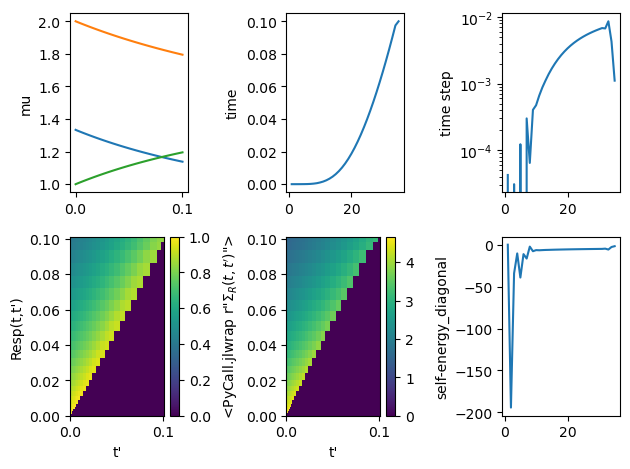

In [153]:
plot_all_moddiag(variables_SBR,sol_SBR)

In [149]:
tmax = 0.1;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
#structure = Reaction_structure(rs_abc2);
variables_SBR_mixed = Reaction_variables(structure,"single");
sol_SBR_mixed = solve_dynamics(structure,variables_SBR_mixed,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.9964519572120375e-5
t: 3.799363881563918e-5
t: 8.023796318218905e-5
t: 0.00017446683632478538
t: 0.00034437669947712235
t: 0.000603745662670098
t: 0.0010343491616860454
t: 0.0015979133086293632
t: 0.0023663235239130896
t: 0.0033597891657360943
t: 0.0046090510448806585
t: 0.006145691879436328
t: 0.007990271644698194
t: 0.01016042067644983
t: 0.012669773273440264
t: 0.015526059335092322
t: 0.01873293906865344
t: 0.022290632057506168
t: 0.026196198799208873
t: 0.03044439971212062
t: 0.03502834399083433
t: 0.03993998101255341
t: 0.04517058775796771
t: 0.0507111520469989
t: 0.05655265888826377
t: 0.06268631274694261
t: 0.06910369484261839
t: 0.07579686580008328
t: 0.08275842727132249
t: 0.08998155067984086
t: 0.09745998095921152
  7.518523 seconds (20.62 M allocations: 1.110 GiB, 3.13% gc time, 77.91% compilation time)


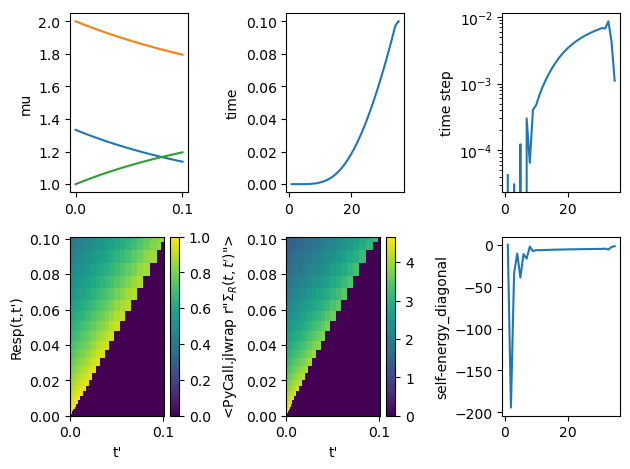

In [150]:
plot_all_moddiag(variables_SBR_mixed,sol_SBR_mixed)

In [154]:
variables_SBR.μ[1,:] - variables_SBR_mixed.μ[1,:]

35-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 2.220446049250313e-16
 1.1102230246251565e-15
 8.43769498715119e-15
 ⋮
 3.1915188269948658e-9
 6.087128134879549e-9
 1.1019923196187165e-8
 1.9028956632638483e-8
 3.14780514987234e-8
 5.00770294120656e-8
 7.687903735842383e-8
 1.1425023771494125e-7
 1.648108685081695e-7
 2.3134951199210718e-7
 3.1671497513485747e-7
 3.505921670754475e-7

In [92]:
tmax = 0.1;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
structure = Reaction_structure(rs_abc2);
variables_mak = Reaction_variables(structure,"single");

sol_mak = solve_dynamics(structure,variables_mak,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 2.249322749330604e-5
t: 6.754752877849986e-5
t: 0.00021622377214516593
t: 0.0003500323911751654
t: 0.00047046014830216495
t: 0.0005788451297164645
t: 0.0006763916129893341
t: 0.0007641834479349168
t: 0.0008431960993859411
t: 0.0009143074856918631
t: 0.0009783077333671928
t: 0.0010907364278409993
t: 0.0012787013660038053
t: 0.0015708856956138514
t: 0.0019209618528816174
t: 0.002305518308458825
t: 0.002808202466625529
t: 0.0036146330210924484
t: 0.004881927906041905
t: 0.006763195596982858
t: 0.009360607819516633
t: 0.013065300831995023
t: 0.018039346831195395
t: 0.02440291986438456
t: 0.032224555250024677
t: 0.04158684975098505
t: 0.052550918304191126
t: 0.06512787890458338
t: 0.07928858287316462
t: 0.09498205863254958
  2.686327 seconds (4.15 M allocations: 258.649 MiB, 1.88% gc time, 98.56% compilation time)


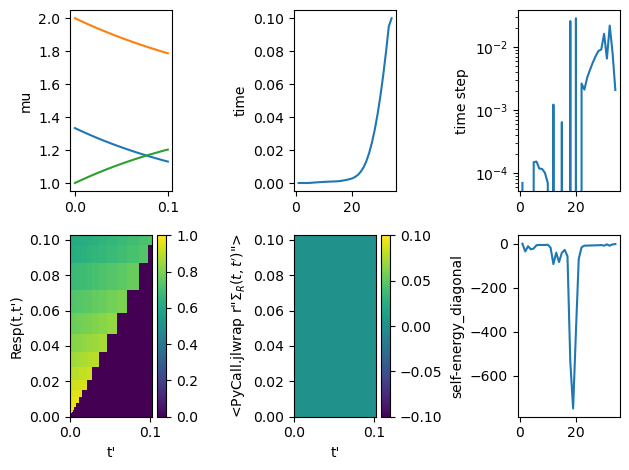

In [93]:
plot_all_moddiag(variables_mak,sol_mak)

In [139]:
tmax = 0.1;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
#structure = Reaction_structure(rs_abc2);
variables_alpha2 = Reaction_variables(structure,"single");

sol_alpha2 = solve_dynamics(structure,variables_alpha2,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.9964519572120375e-5
t: 3.799363881563918e-5
t: 8.023796318218903e-5
t: 0.0001744668363247847
t: 0.0003443766994771127
t: 0.0006037456626700624
t: 0.0010343491616852528
t: 0.0015979133086260113
t: 0.0023663235238817726
t: 0.0033597891655655346
t: 0.004609051044080081
t: 0.006145691876232973
t: 0.007990271633522065
t: 0.010160420641657395
t: 0.01266977317534005
t: 0.015526059081819133
t: 0.01873293846405121
t: 0.02229063071169155
t: 0.02619619598551887
t: 0.030444394151799576
t: 0.03502833354643124
t: 0.0399399622727967
t: 0.04517055550050113
t: 0.05071109857113192
t: 0.05655257321711166
t: 0.06268617970613106
t: 0.06910349403068218
t: 0.07579657047305166
t: 0.08275800317015854
t: 0.08998095483412806
t: 0.09745916050352929
  3.690424 seconds (6.05 M allocations: 391.029 MiB, 1.47% gc time, 97.03% compilation time)


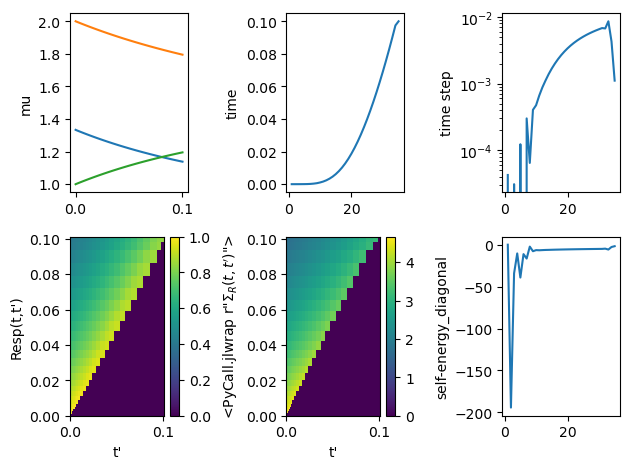

In [140]:
plot_all_moddiag(variables_alpha2,sol_alpha2)

In [207]:
tmax = 0.1;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
structure_abc = Reaction_structure(rs_abc);
m_list, n_list, m_listFULL, n_listFULL, m_listNEW, n_listNEW = mnList(structure_abc)
variables_abc_SBR_mixed = Reaction_variables(structure_abc,"single");
sol_abc_SBR_mixed = solve_dynamics(structure_abc,variables_abc_SBR_mixed,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.974850685411258e-5
t: 3.717363898259486e-5
t: 7.777174433976353e-5
t: 0.00016764164858559452
t: 0.0003278966351719601
t: 0.0005713000506067897
t: 0.0009725858810459583
t: 0.001495781804978557
t: 0.002205365255587255
t: 0.0031193898956215715
t: 0.004264802683225271
t: 0.005669186646436123
t: 0.007350259160761553
t: 0.009322941419982526
t: 0.011598441505145139
t: 0.01418259667793018
t: 0.017077479325019736
t: 0.020281949043047517
t: 0.02379191354475435
t: 0.027601094816184387
t: 0.03170161236948606
t: 0.036084434451093016
t: 0.04073982718845981
t: 0.045657712690390456
t: 0.05082794288105163
t: 0.0562405163831366
t: 0.06188573694067202
t: 0.06775432228030197
t: 0.07383747503545479
t: 0.08012692277638304
t: 0.08661493413197009
t: 0.09329431734373228
  7.006136 seconds (30.87 M allocations: 1.567 GiB, 4.50% gc time, 44.67% compilation time: 47% of which was recompilation)


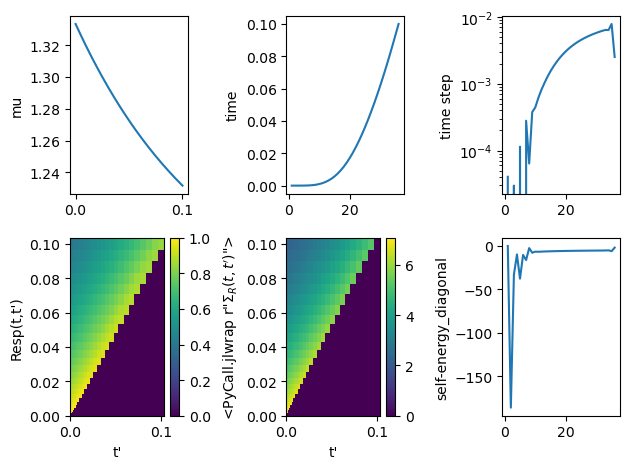

In [208]:
plot_all_moddiag(variables_abc_SBR_mixed,sol_abc_SBR_mixed)

In [197]:
tmax = 0.1;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
#structure_aaa = Reaction_structure(rs_aaa);
variables_abc_SBR = Reaction_variables(structure_abc,"single");
sol_abc_SBR = solve_dynamics(structure_abc,variables_abc_SBR,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.974850685411258e-5
t: 3.717363898259486e-5
t: 7.777174433976353e-5
t: 0.00016764164858559452
t: 0.0003278966351719601
t: 0.0005713000506067897
t: 0.0009725858810459583
t: 0.001495781804978557
t: 0.002205365255587255
t: 0.0031193898956215715
t: 0.004264802683225271
t: 0.005669186646436121
t: 0.007350259160761539
t: 0.009322941419982434
t: 0.011598441505144658
t: 0.014182596677928016
t: 0.01707747932501121
t: 0.020281949043017593
t: 0.023791913544659676
t: 0.027601094815911262
t: 0.03170161236876067
t: 0.036084434449304446
t: 0.040739827184335234
t: 0.04565771268143664
t: 0.05082794286264903
t: 0.056240516347145754
t: 0.061885736873390045
t: 0.06775432215959434
t: 0.07383747482688724
t: 0.08012692242819298
t: 0.0866149335687476
t: 0.09329431645872617
  6.672150 seconds (23.35 M allocations: 1.208 GiB, 4.27% gc time, 61.59% compilation time)


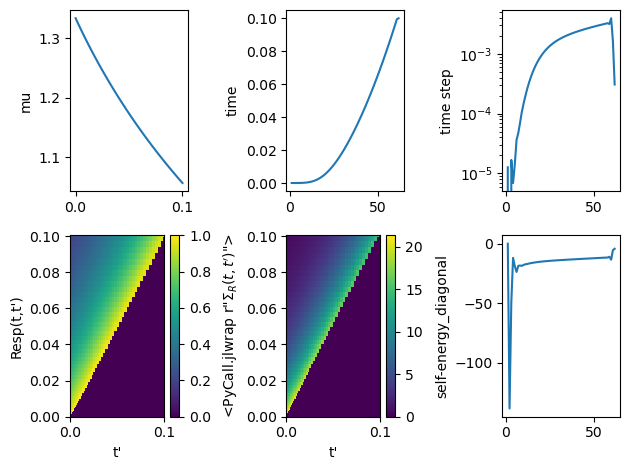

In [198]:
plot_all_moddiag(variables_aaa_SBR2,sol_aaa_SBR2)

In [209]:
variables_abc_SBR.μ[1,:] - variables_abc_SBR_mixed.μ[1,:]

36-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 2.220446049250313e-16
 1.1102230246251565e-15
 9.325873406851315e-15
 ⋮
 6.442793853977946e-9
 1.16879343980969e-8
 2.0240452203168502e-8
 3.3602224114304136e-8
 5.3681905587410483e-8
 8.280771823798716e-8
 1.237121654007467e-7
 1.7948622188512786e-7
 2.5350337451435223e-7
 3.493166023105232e-7
 4.7053368024130293e-7
 6.162870220816075e-7

In [638]:
tmax = 0.1;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
#structure = Reaction_structure(rs_abc2);
variables_explicit = Reaction_variables(structure,"single");

sol_explicit = solve_dynamics(structure,variables_explicit,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 5.999999999999999e-6
t: 6.000006893262263e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.0000132052622826e-6
t: 6.000013259649512e-6
t: 6.000013259649512e-6
t: 6.000013259649512e-6
t: 6.000013259649512e-6
t: 6.000013259649512e-6
t: 6.000013284537371e-6
t: 6.000013307384311e-6
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t: NaN
t:

LoadError: InexactError: trunc(Int64, NaN)

In [639]:
plot_all_moddiag(variables_explicit,sol_explicit)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/harsh/.julia/packages/PyCall/ilqDX/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (30,) and (51,)')
  File "/usr/lib64/python3.11/site-packages/matplotlib/pyplot.py", line 2748, in plot
    return gca().plot(
           ^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/matplotlib/axes/_axes.py", line 1668, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "


In [160]:
function plot_all_moddiag(rxn_variables,solution)
    
    #Plots the diagonal values separately for the self-energy
    #This equalizes the scale difference so that the values are better visible
    
    subplot(231)
    PyPlot.plot(solution.t, rxn_variables.μ[1,:])
    #PyPlot.plot(solution.t, rxn_variables.μ[2,:])
    #PyPlot.plot(solution.t, rxn_variables.μ[3,:])
    ylabel("mu")

    subplot(232)
    PyPlot.plot(1:length(solution.t),solution.t)
    ylabel("time")

    subplot(233)
    PyPlot.plot(1:length(solution.t),solution.w[length(solution.t)])
    ylabel("time step")
    yscale("log")

    subplot(234)
    #imshow(rxn_variables.R[1,:,:])
    pcolor(solution.t,solution.t,rxn_variables.R[1,:,:],shading="auto")
    colorbar()
    #colorbar(shrink=0.6)
    ylabel("Resp(t,t')")
    xlabel("t'")
    
    temp = deepcopy(rxn_variables.Σ_R[1,1:length(solution.t),1:length(solution.t)])
    
    for i in 1:length(solution.t)
        #temp[i,i] *= solution.w[length(solution.t)][i]
        temp[i,i] = 0
    end
    
    subplot(235)
    #imshow(temp)
    pcolor(solution.t,solution.t,temp,shading="auto")
    #colorbar(shrink=0.6)
    colorbar()
    ylabel(r"$\Sigma_R (t,t')$")
    xlabel("t'")
    
    subplot(236)
    PyPlot.plot(1:length(solution.t),diag(rxn_variables.Σ_R[1,1:length(solution.t),1:length(solution.t)].*abs.(solution.w[length(solution.t)])))
    #PyPlot.plot(1:length(solution.t),diag(rxn_variables.Σ_R[1,1:length(solution.t),1:length(solution.t)]))

    ylabel("self-energy_diagonal")
    
    tight_layout()
    
end

plot_all_moddiag (generic function with 1 method)

In [19]:
function plot_all(rxn_variables,solution)
    
    #TODO: Write a function to plot the diagonal separately from the 
    
    subplot(231)
    PyPlot.plot(solution.t, rxn_variables.μ[1,:])
    PyPlot.plot(solution.t, rxn_variables.μ[2,:])
    PyPlot.plot(solution.t, rxn_variables.μ[3,:])
    ylabel("mu")

    subplot(232)
    PyPlot.plot(1:length(solution.t),solution.t)
    ylabel("time")

    subplot(233)
    PyPlot.plot(1:length(solution.t),solution.w[length(solution.t)])
    ylabel("time step")
    yscale("log")

    subplot(234)
    imshow(rxn_variables.R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("Resp")

    subplot(235)
    imshow(rxn_variables.Σ_R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("self-energy")
    
    tight_layout()
    
end

plot_all (generic function with 1 method)

In [206]:
#Define block multiplications, inversions etc with the fast elimination algorithm:

using LinearAlgebra
using Einsum

function block_tri_lower_inverse_old(mat)
    """
    Calculates the inverse of a lower triangular matrix where each elemet itself is a block matrix. Used for mixed SBR series!
    mat should have the first two dimensions coressponding to the block of n, the last two to the time. Assumes there are 1's on the diagonal!
    
    """                    
    len_rows = size(mat, 3)
    len_n = size(mat, 1)
    invM = similar(mat)

    # Do the diagonals first:
    for diag in 1:len_rows
        invM[:, :, diag, diag] .= inv(mat[:, :, diag, diag])
    end

    for row in 2:len_rows
        for col in 1:row - 1
            temp = zeros(size(mat)[1:2])
            for col2 in col:row - 1
                temp .+= mat[:, :, row, col2] * invM[:, :, col2, col]
            end
            invM[:, :, row, col] .= -invM[:, :, row, row] * temp
        end
    end

    return invM
    
end

function block_tri_lower_inverse(mat)
    """
    Calculates the inverse of a lower triangular matrix where each elemet itself is a block matrix. Used for mixed SBR series!
    mat should have the first two dimensions coressponding to the block of n, the last two to the time. Assumes there are 1's on the diagonal!
    
    """
    
    #for row in range(1,len_rows):
    #    D_inv  = np.linalg.inv(mat[:,:,row,row]) #Can get rid of this in principle!
    #    temp_n = np.einsum('ijl,jmlo->imo',mat[:,:,row,:row+1],inv[:,:,:row+1,:row+1],optimize='greedy')
    #    inv[:,:,row,:row+1] = np.einsum('ij,jmk->imk',D_inv,(block_identity(len_n,row+1)[:,:,row]-temp_n[:,:,:row+1]), optimize='greedy')
        
        #print(D_inv)
    
    #TODO ----- 
                        
    len_rows = size(mat, 3)
    len_n    = size(mat, 1)
    invM     = zeros(size(mat)) #similar(mat)
    
    invM[:, :, 1, 1] .= inv(mat[:, :, 1, 1])

    for row in 2:len_rows
        D_inv = inv(mat[:, :, row, row])
        mat_copy = deepcopy(mat[:,:,row,1:row])
        inv_copy = deepcopy(invM[:,:,1:row,1:row])
        
        @einsum temp_n[i,m,o] := mat_copy[i,j,l] * inv_copy[j,m,l,o]
                       #temp_n2 = block_identity(len_n,row+1)[:,:,row].-temp_n[:,:,1:row]
                temp_n2 = block_identity(len_n,row)[:,:,row,1:row] .- temp_n[:,:,1:row]
        @einsum inv_temp[i,m,k] := D_inv[i,j] * temp_n2[j,m,k]
        
        invM[:,:,row,1:row] .= inv_temp[:,:,:]
            
    end

                        
    return invM
                        
end
    
function block_mat_mul(mat1,mat2)
    """
    Calculates the matrix product between two compatible matrices etc which have the block structure! The first two indices corresspond to the list index.
    """
                                    
    len_rows = size(mat1, 3)
    mul = similar(mat1)

    for i in 1:len_rows, j in 1:len_rows, k in 1:len_rows
        mul[:, :, i, j] .+= mat1[:, :, i, k] * mat2[:, :, k, j]
    end

    @einsum mul[i,n,k,o] := mat1[i,j,k,l] * mat2[j,n,l,o]
    
    return mul

end

function block_lower_shift(mat)
                                    
    len_rows = size(mat, 3)
    L = diagm(-1 => ones(len_rows - 1))

    #@einsum shifted[i,j,k,m] :=  mat[i,j,k,l] * L[l,m]
    @einsum shifted[i,j,k,m] :=  L[k,l] * mat[i,j,l,m] 
    
    return shifted
                                    
end
    

function block_mat_mix_mul(mat1,mat2)
    """
    Calculates the matrix product between a matrix which has the block structure with another matrix which has a structure with only one n but two time indices! The first two indices corresspond to the list index.
    """
    
    #len_rows = np.shape(mat1)[2]
    #mul      = np.zeros([np.shape(mat1)[0],np.shape(mat1)[2],np.shape(mat1)[3]])
    
    #for i in range(len_rows):
        #for j in range(len_rows):
            #for k in range(len_rows):
                #mul[:,i,j] += np.matmul(mat1[:,:,i,k],mat2[:,k,j])
    
    #mul = np.einsum('ijkl,jlm->ikm',mat1,mat2,optimize='optimal')
                                    
    @einsum mul[i,k,m] := mat1[i,j,k,l] * mat2[j,l,m]
    
    return mul
                                    
end
    
function block_mat_vec_mul(mat,vec)
    """
    Calculates the matrix product between a compatible matrix and a vector etc which have the block structure! The first two indices corresspond to the list index.
    """
                                            
    len_rows = size(mat, 3)
    mul = zeros(size(mat)[1], len_rows)

    for i in 1:len_rows, k in 1:len_rows
        mul[:, i] .+= mat[:, :, i, k] * vec[:, k]
    end

    return mul
                                            
end

function block_vec_mat_mul(vec,mat)
    """
    Calculates the matrix product between a compatible vector and a matrix which have the block structure! The first two indices corresspond to the list index.
    """
                                                    
    len_rows = size(mat, 3)
    mul = zeros(size(mat)[1], len_rows)

    for i in 1:len_rows, k in 1:len_rows
        mul[:, i] .+= vec[:, k] * mat[:, :, k, i]
    end

    return mul
                                                    
end
    
function block_vec_mat_mul_single_sp(vec,mat)
    """
    Calculates the matrix product between a compatible vector and a matrix which have the block structure! 
    Only the first index corresspond to the list index and the vec has no time index
    """
    
    len_rows = size(mat, 2)
    mul = zeros(len_rows, len_rows)

    for i in 1:size(mat, 1)
        mul[:,:] .+= vec[i] * mat[i,:,:]
    end

    return mul
    
end
    
function block_identity(dim_list,dim_time)
    """
    Creates the identity for the block matrix system
    """
    
    identity = zeros(dim_list,dim_list,dim_time,dim_time)
    
    for i in 1:dim_time
        for j in 1:dim_list
            identity[j,j,i,i] = 1.
        end
    end
        
    return identity
                                                            
end


block_identity (generic function with 1 method)

In [106]:
function c_mn_no_mu(structure,int_rxn_index,m,n)
    #"""
    #Creates the c_mn for each individual beta reaction (without the \mu factors)
    #"""
    
    if any(n.-structure.stochiometry_react[:,int_rxn_index] .> 0.)
        c_mnBeta = 0.

    else
        c_mnBeta = structure.rate_interaction[int_rxn_index]*(prod(
        binomial.(structure.stochiometry_prod[:,int_rxn_index],m).*(1 .^(structure.stochiometry_prod[:,int_rxn_index].-m))
        ) .- prod(binomial.(structure.stochiometry_react[:,int_rxn_index],m).*(1 .^(structure.stochiometry_react[:,int_rxn_index].-m) )
        ))*prod(binomial.(structure.stochiometry_react[:,int_rxn_index],n))
    
    end
    
    return c_mnBeta
end

function c_mn(structure,variables,int_rxn_index,m,n,time)
    #"""
    #Creates the c_mn for each individual beta reaction (including the \mu factors)
    #"""

    if any(n.-structure.stochiometry_react[:,int_rxn_index] .> 0.)
        
        c_mnBeta = 0.

    else
        if time>1
        
        c_mnBeta = structure.rate_interaction[int_rxn_index]*(prod(
        binomial.(structure.stochiometry_prod[:,int_rxn_index],m).*(1 .^(structure.stochiometry_prod[:,int_rxn_index].-m))
        ) .- prod(binomial.(structure.stochiometry_react[:,int_rxn_index],m).*(1 .^(structure.stochiometry_react[:,int_rxn_index].-m) )
        )).*prod(binomial.(structure.stochiometry_react[:,int_rxn_index],n)).*prod(variables.μ[:,time-1] .^(structure.stochiometry_react[:,int_rxn_index].-n))
        
        #Note that this cmn is defined with the time shift t- in \mu! ## PAY ATTENTION!
        else
            c_mnBeta = 0.
        end
        
    end
        
    return c_mnBeta
    
end

function c_mnFULL(structure,variables,m,n,time)

    retval = 0.
    
    for k in 1:structure.num_interactions
        retval += c_mn(structure,variables,k,m,n,time)
    end
    
    return retval
    
end

function c_mnFULL_test(structure,variables,m,n)
    
    #This function tests if a partciular cmn_full (no_mu) is zero or not.
    
    retval = 0.
    
    #TODO this thing
    
    for k in 1:structure.num_interactions
        retval += c_mn_no_mu(structure,k,m,n)
    end
    
    return retval
    
end

function create_c_mn_dict(structure,variables,m_list,n_list)
    #"""
    #Creates a dictionary for the c_mn for each individual beta reaction (without the \mu factors) where the output is a dictionary and can be looked up by [int(rxn_index),tuple(m),tuple(n)]
    #"""

    c_mn_dict = Dict()

    for int_rxn_index in range(1,structure.num_interactions)
        
        #Note that for the m_list, n_list above, they should be the m-list, n-list 
        #corresponding to each reaction individually 
        for m in m_list[int_rxn_index]
            for n in n_list[int_rxn_index]
                
                #Can already NOT SAVE many of the c_mn which are zero at this point!
                
                c_mn_dict[(int_rxn_index,m,n)] = c_mn_no_mu(structure,int_rxn_index,m,n)
                #c_mn_dict[(int_rxn_index,tuple(m),tuple(n))] = c_mn_no_mu(structure,int_rxn_index,m,n)
            
            end
        end
    end
    
    return c_mn_dict

end             

create_c_mn_dict (generic function with 1 method)

In [172]:
function mnList(structure)
    
    num_int = structure.num_interactions
    num_species = structure.num_species
    s_i = structure.stochiometry_prod
    r_i = structure.stochiometry_react
    
    m_list = []
    n_list = []
    m_listFULL = []
    n_listFULL = []
    
    for i in 1:num_int
        
        x = vec(collect(product([0:Int(max(s_i[j,i], r_i[j,i])) for j in 1:num_species]...)))
        y = vec(collect(product([0:Int(r_i[j,i]) for j in 1:num_species]...)))
        
        #The above creates tuples(Int, Int ... , Int (len = num_species)) which needs to be converted to an array,
        # Otherwise it runs into issues later!
        
        x′ = []
        y′ = []      
        
        push!(x′,[[Int(j) for j in k] for k in x])
        push!(y′,[[Int(j) for j in k] for k in y])
        
        push!(m_list, x′[1])
        push!(n_list, y′[1])
    end
    
    #Construct the full lists here
    max1 = zeros(Int,num_species)
    max2 = zeros(Int,num_species)
    
    for j in 1:num_species
    
        max1[j] = maximum(cat(collect(s_i[j,i] for i in 1:num_int),collect(r_i[j,i] for i in 1:num_int),dims=1))
        max2[j] = maximum(collect(r_i[j,i] for i in 1:num_int))
    end
    
    
    a = vec(collect(product([0:max1[j] for j in 1:num_species]...)))
    b = vec(collect(product([0:max2[j] for j in 1:num_species]...)))

    push!(m_listFULL, a)
    push!(n_listFULL, b)
    
    #Also define the NEW lists which are just the intersection of the lists across the different reactions,
    #the FULL lists are overkills and have extra elements
    
    m_listNEW = union(collect.(m_list[j] for j in 1:num_int)...)
    n_listNEW = union(collect.(n_list[j] for j in 1:num_int)...)
    
    #create excluded lists as well:

    return m_list, n_list, m_listFULL, n_listFULL, m_listNEW, n_listNEW
    
end


m_list, n_list, m_listFULL, n_listFULL, m_listNEW, n_listNEW = mnList(structure_aaa)


(Any[[[0], [1], [2]]], Any[[[0], [1], [2]]], Any[[(0,), (1,), (2,)]], Any[[(0,), (1,), (2,)]], [[0], [1], [2]], [[0], [1], [2]])

## Reading:

In [98]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

#touch("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_1.csv")

MF_explcit  = readdlm("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_MF.csv")

MF_explcit_resp = readdlm("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_MF_resp.csv") 

#abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_1.csv", "w")
#mn = convert(Array,mu_SBR[:])
    
#writedlm(abc, vcat(transpose(sol_SBR.t),transpose(mn))) 
#close(abc)


3468×1 Matrix{Float64}:
 1.0
 1.0
 1.0
 0.9999900000276666
 0.999993333347111
 0.9999940000090001
 0.9999650003043322
 0.9999766668182216
 0.999979000099
 0.9998825373610156
 0.9999216909839055
 0.9999295214555884
 0.9996572951377519
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.718887762039528
 0.8047630066918372
 0.8172523333238333

In [100]:
variables_mak.μ[1,:] - MF_explcit[2,:]

34-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 -2.220446049250313e-16
 -2.220446049250313e-16
 -2.220446049250313e-16
 -4.440892098500626e-16
 -4.440892098500626e-16
 -6.661338147750939e-16
 -8.881784197001252e-16
 -8.881784197001252e-16
 -8.881784197001252e-16
 -8.881784197001252e-16
 -6.661338147750939e-16
  0.0

In [128]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

#touch("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_1.csv")

alpha2_explcit  = readdlm("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_alpha2.csv")

#MF_explcit_resp = readdlm("/home/harsh/Work/code/KadanoffBaym.jl/data/ABC_MF_resp.csv") 

#abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_1.csv", "w")
#mn = convert(Array,mu_SBR[:])
    
#writedlm(abc, vcat(transpose(sol_SBR.t),transpose(mn))) 
#close(abc)


4×34 Matrix{Float64}:
 0.0      1.0e-6   6.0e-6   2.24932e-5  …  0.077045  0.0923017  0.1
 1.33333  1.33333  1.33331  1.33327        1.17083   1.14719    1.13642
 2.0      1.99999  1.99998  1.99994        1.83164   1.80571    1.79363
 1.0      1.00001  1.00002  1.00006        1.16251   1.18614    1.19691

In [144]:
alpha2_explcit[1,:] - sol_alpha2.t[1:34]

34-element Vector{Float64}:
  0.0
  0.0
  0.0
  2.528711881389083e-6
  2.9553873055961828e-5
  0.00013598578210090556
  0.00017556551902865404
  0.00012608340493963578
 -2.490058409633511e-5
 -0.0003579576063702446
 -0.0008337299242438504
 -0.0015231274933391742
 -0.0024454817534785424
  ⋮
 -0.023797258300567673
 -0.025861307858237093
 -0.027171583282954694
 -0.027569022086473084
 -0.02693559251803465
 -0.0251910360335705
 -0.022244723341083746
 -0.018024043387561278
 -0.012507433355342726
 -0.0057129839820990735
  0.002320790688274968
  0.002540839496470715

In [146]:
alpha2_explcit[2,:] - variables_alpha2.μ[1,1:34]

34-element Vector{Float64}:
  0.0
  1.333377852574813e-12
  7.999823026239028e-12
 -6.742994955732939e-6
 -7.879481790351583e-5
 -0.00036244170289734257
 -0.0004675587457871888
 -0.0003353441646609667
  6.655718710568692e-5
  0.0009507809786792887
  0.0022093646721050852
  0.004025148197082551
  0.006440487357786795
  ⋮
  0.056231813524337815
  0.0596629176665473
  0.060886744852234775
  0.05965181688972532
  0.055907823133579226
  0.049791992882762814
  0.04150455127985908
  0.03136174319179097
  0.019829515515743745
  0.007445765961348716
 -0.005261764154989024
 -0.005226194330566036

## Solving MAK ODE:

In [35]:
ode_mak = [sol.u[i][j] for i in 1:10, j in 1:3]

10×3 Matrix{Float64}:
 1.33333  2.0      1.0
 1.33333  2.0      1.0
 1.33332  1.99998  1.00002
 1.33325  1.99992  1.00008
 1.33292  1.99958  1.00042
 1.33126  1.99792  1.00208
 1.32304  1.98969  1.01029
 1.28433  1.95052  1.049
 1.13825  1.79512  1.19508
 1.13486  1.79131  1.19848

In [ ]:
using DifferentialEquations 

[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]


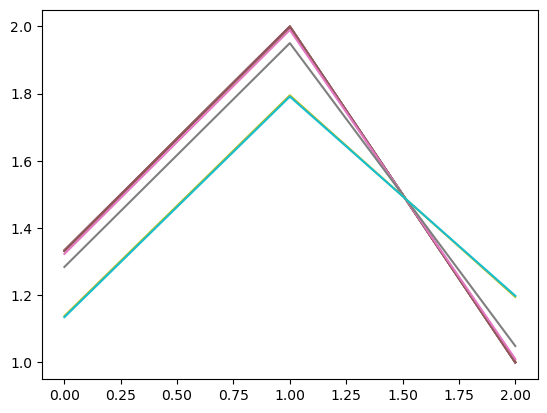

10-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb2d0a4eed0>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c6511310>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c65116d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c6511ad0>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c6511e90>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c6512310>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c6512910>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c6512dd0>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c6511f90>
 PyObject <matplotlib.lines.Line2D object at 0x7fb2c6513690>

In [20]:
oprob = ODEProblem(rs_abc2,[],(tstart,tmax))
sol = solve(oprob,saveat = MF_explcit[1,:],)
plot(sol)

## Saving:

In [173]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

touch("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_1.csv")

abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_1.csv", "w")
mn = convert(Array,mu_SBR[:])
    
writedlm(abc, vcat(transpose(sol_SBR.t),transpose(mn))) 
close(abc)

In [174]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

touch("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_2.csv")

abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_2.csv", "w")
mn = convert(Array,mu_SBR2[:])
    
writedlm(abc, vcat(transpose(sol_SBR2.t),transpose(mn))) 
close(abc)

In [ ]:
sol

##OLD with incorrect time arguments:

function solve_dynamics(structure,variables,atol,rtol,tmax,tstart=0.)
    
    function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy correction to the mean
        """

        retval = zero(μ[t1])

        for k in 1:tmax
            retval +=  Σ[t1,k].*hs[k]
        end

        return retval
    end

    function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy corrections to the response
        """

        retval = zero(R[t1,t2])

        for k in t2:t1
            retval += Σ[t1,k].*R[k,t2]*hs[k] 
        end

        return retval
    end
    
    # Right-hand side for the "vertical" evolution
    function fv!(structure, variables, out, times, h1, h2, t, t′)

        retval  = zero(variables.R[t,t′])
        corr    = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        
        for j in 1:structure.num_species
            retval[j] += -structure.rate_destruction[j].*variables.R[j,t,t′]
        end

        out[1]  = retval .+ corr

    end

    #diagonal evolution
    function fd!(structure, variables, out, times, h1, h2, t, t′)
        out[1] = zero(out[1])
    end

    # one-time equation for condensate amplitude
    function f1!(structure, variables, out, times, h1, t)

        retval  = zero(variables.μ[t])
        corr    = integrate1(h1, t, variables.Σ_μ, variables.μ)
        
        for j in 1:structure.num_species
            retval[j] += structure.rate_creation[j] .- structure.rate_destruction[j].*variables.μ[j,t]
        end
        
        out[1]  = retval .+ corr
        
        print("f1 t = ", t,'\n')
        print("mu = ", variables.μ[t],'\n')

    end
    
    # Callback function for the self-energies
    function self_energy_mak!(structure, variables, times, h1, h2 , t, t′)

        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end

        for i in 1:structure.num_species
            temp0    = zeros(Int,structure.num_species)
            temp1    = zeros(Int,structure.num_species)
            temp1[i] = 1
            
            variables.Σ_R[i,t,t′] = 0. #Remove these both -- overkill!s
            variables.Σ_μ[i,t,t′] = 0.
            
            variables.Σ_R[i,t,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
            variables.Σ_μ[i,t,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]

        end
    end
    
    function self_energy_alpha2!(structure, variables, times, h1, h2 , t, t′)

        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        temp0    = zeros(Int,structure.num_species)
        
        for i in 1:structure.num_species
            
            temp1    = zeros(Int,structure.num_species)
            temp1[i] = 1
            
            variables.Σ_R[i,t,t′] = 0. #Overkill!
            variables.Σ_μ[i,t,t′] = 0. #Overkill!
            variables.Σ_R[i,t,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
            variables.Σ_μ[i,t,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]
            
            for n ∈ n_listNEW
                if n ∉ [temp0,temp1]
                    
                    variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t)*
                    c_mnFULL(structure,variables,n,temp1,t′)*prod(factorial.(n).*variables.R[t,t′].^n)
                    
                end
                
                if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)
                    
                    variables.Σ_μ[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t)*
                    c_mnFULL(structure,variables,n,temp0,t′)*prod(factorial.(n).*variables.R[t,t′].^n)

                end
            end
        end
    end
    
    function self_energy_SBR!(structure, variables, times, h1, h2 , t, t′)
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        #print("Sigma t = ", t ,"\n")
        
        if t′ == 1
        
            temp0  = zeros(Int,structure.num_species)
            id     = diagm(ones(t))
            L      = diagm(-1=>ones(t-1))
            
            variables.Σ_μ[:,t,1:t] .= 0. #Check these zero initializations!
            variables.Σ_R[:,t,1:t] .= 0.

            Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) #Temporary variables declared to hold the field values!
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])

            for i in 1:structure.num_species

                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1

                Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
                Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]

            end

            for n in n_listNEW
                
                #This loop is executed iff cnn != 0 #and cN0 != 0
                if c_mnFULL_test(structure,variables,n,n) != 0 && c_mnFULL_test(structure,variables,n,temp0) != 0

                    cNN = collect(c_mnFULL(structure,variables,n,n,tt) for tt in 1:t)
                    Γ   = collect(prod(factorial.(n) .* variables.R[:,tt,ttt] .^n) for tt in 1:t, ttt in 1:t)                
                    cN0 = collect(c_mnFULL(structure,variables,n,temp0,ttt).*Γ[tt,ttt] for tt in 1:t, ttt in 1:t)

                    #The following creates the \Chi matrix (with the shift), but also multiples the columns by the time step size
                    χ   = collect(cNN[ttt].*Γ[tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L
                    
                    #print(diag(χ))
                    
                    Ξ   = tril(id .- χ)      #Make the matrix ecplicitly lower triangular!
                    LAPACK.trtri!('L','U',Ξ) #LAPAC functions to invert the triangular matrix here!
                    ΞcN0 = Ξ*cN0

                    for i in 1:structure.num_species

                        temp1    = zeros(Int,structure.num_species)
                        temp1[i] = 1
                        #Mf       = diagm([c_mnFULL(structure,variables,n,temp1,tt) for tt in 1:t])
                        #ΞMf      = Ξ*Mf

                        if n ∉ [temp0,temp1] && c_mnFULL_test(structure,variables,n,temp1) != 0 && c_mnFULL_test(structure,variables,temp1,n) != 0
                            cN1  = collect(c_mnFULL(structure,variables,n,temp1,ttt).*Γ[tt,ttt] for tt in 1:t, ttt in 1:t)
                            ΞcN1 = Ξ*cN1

                            Σ_R_temp[i,1:t] += (c_mnFULL(structure,variables,temp1,n,t).*ΞcN1)[t,1:t]
                            #variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*ΞcN1[t,t′]

                        end

                        if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)

                            Σ_μ_temp[i,1:t] += (c_mnFULL(structure,variables,temp1,n,t).*ΞcN0)[t,1:t]
                            #variables.Σ_μ[i,t,t′] += (c_mnFULL(structure,variables,temp1,n,t).*ΞcN0)[t,t′]

                        end
                    end
                end
            end

            #print("t = ",t," t' = ", t′, "\n" )

            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t] 
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t] 
            
        end
    end
    
    
    
    function self_energy_SBR_explicit_ABC!(structure, variables, times, h1, h2 , t, t′)
        
        #TODO: Incomplete!
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        if t′ == 1
            
            variables.Σ_μ[:,t,1:t] .= 0. #Check these zero initializations!
            variables.Σ_R[:,t,1:t] .= 0.
            
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) # Temporary variables to store the value of the self-energy!
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])

            id = diagm(ones(t))
            L  = diagm(-1=>ones(t-1))
            
            Σ_μ_temp[1,t] += -structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            Σ_μ_temp[2,t] += -structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            Σ_μ_temp[3,t] += structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            
            Σ_R_temp[1,t] += -structure.rate_interaction[1].*variables.μ[2,t]./h1[t]
            Σ_R_temp[2,t] += -structure.rate_interaction[1].*variables.μ[1,t]./h1[t]
            
            #See that the time arguments are properly multiplied!
            #shifted1 = (variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L

            #shifted2 = (variables.μ[1,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t] .+ 
            #            variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L

            #shifted3 = (variables.μ[2,1:t].*variables.Σ_R[1,1:t,1:t].*h1[1:t] .+
            #            variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L
            
            #shifted1 = zero((variables.Σ_R[1,1:t,1:t])
            #shifted2 = zero((variables.Σ_R[1,1:t,1:t])
            #shifted3 = zero((variables.Σ_R[1,1:t,1:t])
            
                
            shifted1 = collect(variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt]
                            for tt in 1:t, ttt in 1:t)*L

            shifted2 = collect(variables.μ[1,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] .+ 
                        variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L

            shifted3 = collect(variables.μ[2,ttt].*variables.Σ_R[1,tt,ttt].*h1[ttt] .+
                        variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L


            Ξ  = inv(tril(id + structure.rate_interaction[1].*shifted1))
            Ξ2 = inv(tril(id + structure.rate_interaction[1].*shifted2))
            Ξ3 = inv(tril(id + structure.rate_interaction[1].*shifted3))
            
            #print(Ξ,'\n')

            Σ_R_temp[1,1:t] += structure.rate_interaction[1] .^2 .*((shifted1+shifted2)*Ξ2)[t-1,1:t]  
            Σ_R_temp[2,1:t] += structure.rate_interaction[1] .^2 .*((shifted1+shifted3)*Ξ3)[t-1,1:t]
            
            #print((shifted1+shifted2)*Ξ2,'\n')
            
            Σ_μ_temp[1,1:t] += structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            Σ_μ_temp[2,1:t] += structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            Σ_μ_temp[3,1:t] += -structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            
            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t]
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t] 

            
        end
        
    end
    
    function self_energy_SBR_mixed!(structure, variables, times, h1, h2 , t, t′)
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end        
        
        if t′ == 1 
        # Only do the self-energy calcultion for teh first value of t'
        # all the values for t' from 1 to t are stored in this iteration
            
            variables.Σ_μ[:,t,1:t] .= 0. #Check these zero initializations!
            variables.Σ_R[:,t,1:t] .= 0.
            
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) # Temporary variables to store the value of the self-energy!
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])
            
            temp0    = zeros(Int,structure.num_species)

            for i in 1:structure.num_species

                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1
                
                #variables.Σ_R[i,t,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
                #variables.Σ_μ[i,t,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]
                #The above lines implements when it when we explcitly run the self-eenrgy for t,t'
                
                Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
                Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]

            end

            #We will do this first for \mu and then for R
            
            #Creating the a list which has the non-zero entries for \Sigma_mu
            n_listNEW_μ = []

            for n in n_listNEW
                if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0) && c_mnFULL_test(structure,variables,n,temp0) != 0
                    push!(n_listNEW_μ,n)                
                end
            end

            cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_μ, n′′ in n_listNEW_μ,  tt in 1:t)
            Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_μ, tt in 1:t, ttt in 1:t)        
            cN0 = collect(c_mnFULL(structure,variables,n_listNEW_μ[n′],temp0,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_μ), tt in 1:t, ttt in 1:t)
            χ   = collect(cMN[n′,n′′,ttt].*Γ[n′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_μ), n′′ in 1:length(n_listNEW_μ), tt in 1:t, ttt in 1:t )
            Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_μ),t).-block_lower_shift(χ))
            Ξ2  = block_mat_mix_mul(Ξ,cN0)

            for i in 1:structure.num_species
                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1
                c1N      = collect(c_mnFULL(structure,variables,temp1,n′,t) for n′ in n_listNEW_μ)
                #variables.Σ_μ[i,t,t′] += block_vec_mat_mul_single_sp(c1N,Ξ2)[t,t′]
                #The above line implements when it when we explcitly run the self-eenrgy for t,t'

                Σ_μ_temp[i,1:t] .+= block_vec_mat_mul_single_sp(c1N,Ξ2)[t,1:t]
            end


            #Now we do the calculation for \Sigma_R species wise!

            for i in 1:structure.num_species

                temp1       = zeros(Int,structure.num_species)
                temp1[i]    = 1
                n_listNEW_R = []

                for n in n_listNEW
                    if n ∉ [temp0,temp1] && c_mnFULL_test(structure,variables,n,temp1) != 0 && c_mnFULL_test(structure,variables,temp1,n) != 0
                        push!(n_listNEW_R,n)
                    end
                end
                
                if length(n_listNEW_R) > 0

                    cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_R, n′′ in n_listNEW_R,  tt in 1:t)
                    Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_R, tt in 1:t, ttt in 1:t)        
                    χ   = collect(cMN[n′,n′′,ttt].*Γ[n′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_R), n′′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
                    Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_R),t).-block_lower_shift(χ))
                    cN1 = collect(c_mnFULL(structure,variables,n_listNEW_R[n′],temp1,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
                    Ξ2  = block_mat_mix_mul(Ξ,cN1)
                    c1N = collect(c_mnFULL(structure,variables,temp1,n′,t) for n′ in n_listNEW_R)

                    #variables.Σ_R[i,t,t′] += block_vec_mat_mul_single_sp(c1N,Ξ2)[t,t′]
                    #The above line implements when it when we explcitly run the self-eenrgy for t,t'
                    
                    Σ_R_temp[i,1:t] .+= block_vec_mat_mul_single_sp(c1N,Ξ2)[t,1:t]
                end
            end

            #print("t = ",t," t' = ", t′, "\n" )
            
            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t] 
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t]
            
        end
        
        #This code inverts a larger matrix with temp1 included from the beginnig, but then 
        #we eclude the temp1 for sp 1 when calcultating the correction for that species. HAS ISSUES! Does not match 
        #Maybe this is inaccurate, because inverting the entire block with prohibited species is not correct?
                
        #n_listNEW_R = []
        
        #for n in n_listNEW
        #    if n ∉ [temp0] && c_mnFULL_test(structure,variables,n,temp0) != 0
        #        push!(n_listNEW_R,n)
        #    end
        #end
        
        #cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_R, n′′ in n_listNEW_R,  tt in 1:t)
        #Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_R, tt in 1:t, ttt in 1:t)        
        #χ   = collect(cMN[n′,n′′,ttt].*Γ[n′′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_R), n′′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
        #Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_R),t).-block_lower_shift(χ))
        
        #for i in 1:structure.num_species
        #    temp1    = zeros(Int,structure.num_species)
        #    temp1[i] = 1
        #    cN1      = collect(c_mnFULL(structure,variables,n_listNEW_R[n′],temp1,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
        #    Ξ2       = block_mat_mix_mul(Ξ[n_listNEW_R .!= [temp1],n_listNEW_R .!= [temp1],:,:],cN1[n_listNEW_R .!= [temp1],:,:])
        #    c1N      = collect(c_mnFULL(structure,variables,temp1,n′,t) for n′ in n_listNEW_R)
        #    variables.Σ_R[i,t,t′] += block_vec_mat_mul_single_sp(c1N[n_listNEW_R .!= [temp1]],Ξ2)[t,t′]            
        #end
        
        
    end
        
    
    @time sol = kbsolve!(
    (x...) -> fv!(structure, variables, x...),
    (x...) -> fd!(structure, variables, x...),
    [variables.R],
    (tstart, tmax);
    callback = (x...) -> self_energy_SBR!(structure, variables, x...),
    #callback = (x...) -> self_energy_SBR_mixed!(structure, variables, x...),
    #callback = (x...) -> self_energy_SBR_explicit_ABC!(structure, variables, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [variables.μ],
    f1! = (x...) -> f1!(structure, variables, x...))
    
    return sol
end

function self_energy_SBR_overkill!(structure, variables, times, h1, h2 , t, t′)
        
        #Also later execute it only for t' == 1
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        temp0  = zeros(Int,structure.num_species)
        id     = diagm(ones(t))
        L      = diagm(-1=>ones(t-1))
        
        Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) #Some temporary variables declared to hold the field values!
        Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])
        
        for i in 1:structure.num_species
            
            temp1    = zeros(Int,structure.num_species)
            temp1[i] = 1
            
            #variables.Σ_R[i,t,t′] = 0. #These are wrong, do something with these!
            #variables.Σ_μ[i,t,t′] = 0. #These are wrong, do something with these!
            
            #variables.Σ_R[i,t,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
            #variables.Σ_μ[i,t,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]
            
            Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
            Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]
            
        end
        
        for n in n_listNEW
            
            if c_mnFULL_test(structure,variables,n,n) != 0 && c_mnFULL_test(structure,variables,n,temp0) != 0
                
                #This loop is executed iff cnn != 0 #and cN0 != 0
                
                cNN = collect(c_mnFULL(structure,variables,n,n,tt) for tt in 1:t)                
                Γ   = collect(prod(factorial.(n) .* variables.R[:,tt,ttt] .^n) for tt in 1:t, ttt in 1:t)                
                cN0 = collect(c_mnFULL(structure,variables,n,temp0,ttt).*Γ[tt,ttt] for tt in 1:t, ttt in 1:t)

                #The following creates the \Chi matrix (with the shift), but also multiples the columns by the time step size
                χ   = collect(cNN[ttt].*Γ[tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L

                Ξ   = tril(id .- χ) #Make the matrix ecplicitly lower triangular!
                LAPACK.trtri!('L','U',Ξ) #LAPAC functions to invert the triangular matrix here!
                ΞcN0 = Ξ*cN0
                
                for i in 1:structure.num_species

                    temp1    = zeros(Int,structure.num_species)
                    temp1[i] = 1
                    #Mf       = diagm([c_mnFULL(structure,variables,n,temp1,tt) for tt in 1:t])
                    #ΞMf      = Ξ*Mf

                    if n ∉ [temp0,temp1] && c_mnFULL_test(structure,variables,n,temp1) != 0 && c_mnFULL_test(structure,variables,temp1,n) != 0
                        cN1  = collect(c_mnFULL(structure,variables,n,temp1,ttt).*Γ[tt,ttt] for tt in 1:t, ttt in 1:t)
                        ΞcN1 = Ξ*cN1
                        
                        Σ_R_temp[i,t′] += c_mnFULL(structure,variables,temp1,n,t).*ΞcN1[t,t′]
                        #variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*ΞcN1[t,t′]
                        
                        #variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*(Ξ*Mf)[t,t′]
                    end

                    if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)
                        
                        Σ_μ_temp[i,t′] += (c_mnFULL(structure,variables,temp1,n,t).*ΞcN0)[t,t′]
                        #variables.Σ_μ[i,t,t′] += (c_mnFULL(structure,variables,temp1,n,t).*ΞcN0)[t,t′]
                        
                        #variables.Σ_μ[i,t,t′] += (c_mnFULL(structure,variables,temp1,n,t).*ΞMv)[t,t′]
                        #variables.Σ_μ[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*(Ξ*Mv)[t,t′]
                        #variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*(Ξ*Mf)[t,t′]
                    end
                end
            end
        end
        
        print("t = ",t," t' = ", t′, "\n" )
        
        variables.Σ_R[:,t,t′] .= Σ_R_temp[:,t′] 
        variables.Σ_μ[:,t,t′] .= Σ_μ_temp[:,t′] 
        
    end